In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import pickle
import copy
import math

from utilities import *

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

PyTorch Version: 1.11.0+cu113
Torchvision Version: 0.12.0+cu113
GPU is available? True


In [2]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imported datasets
For the testing and comparison of our algorithms we will use the following datasets:

1. MNIST
2. FashionMNIST
3. CIFAR10

In [3]:
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])

# change the flag to choose the dataset to work with
dataset_flag = 0

if dataset_flag ==0:
  trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
  testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)
elif dataset_flag ==1:
  trainset = datasets.FashionMNIST('../data', train=True, download=True, transform=ts)
  testset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=ts)
else:
  trainset = datasets.CIFAR10('../data', train=True, download=True, transform=ts)
  testset = datasets.CIFAR10(root='../data', train=False, download=True, transform=ts)

In [4]:
"""
from sklearn import datasets
from sklearn.model_selection import train_test_split

boston = datasets.load_boston()
X = boston.data
y = boston.target
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

x_train = torch.from_numpy(x_train).to(device = device)
x_test = torch.from_numpy(x_test).to(device = device)
y_train = torch.from_numpy(y_train).to(device = device)
y_test = torch.from_numpy(y_test).to(device = device)

x_train = x_train.T.float()
x_test = x_test.T.float()

N = x_train.shape[1]
N_test = x_test.shape[1]
"""

'\nfrom sklearn import datasets\nfrom sklearn.model_selection import train_test_split\n\nboston = datasets.load_boston()\nX = boston.data\ny = boston.target\nx_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nx_train = torch.from_numpy(x_train).to(device = device)\nx_test = torch.from_numpy(x_test).to(device = device)\ny_train = torch.from_numpy(y_train).to(device = device)\ny_test = torch.from_numpy(y_test).to(device = device)\n\nx_train = x_train.T.float()\nx_test = x_test.T.float()\n\nN = x_train.shape[1]\nN_test = x_test.shape[1]\n'

# Dataset preprocessing

In [5]:
x_train, y_train, x_test, y_test, y_train_one_hot, y_test_one_hot, I1, I2 = load_dataset(trainset, testset, 10)

# We move to GPU
x_train = x_train.to(device = device)
x_test = x_test.to(device = device)
y_train = y_train.to(device = device)
y_test = y_test.to(device = device)
y_train_one_hot = y_train_one_hot.to(device = device)
y_test_one_hot = y_test_one_hot.to(device = device)

# Architecture initialization

For the MultiLayerPerceptron we have the parameters **input_size** , **hidden_size**,**output_size** corresponding to the size of the input layer, the hidden layer and the output layer, respectively.

The MLP only has 3 layers like https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb as a starting point.

Also we use ReLU currently for the same reason.

In [6]:
input_size = x_train.shape[0]
hidden_size = 1600
output_size = 10

# Training

Note: Fix it so that it moves everything to device in the following function and that it does the label sample split here

In [7]:
def update_v_js(U1, U2, W, b, rho, gamma):
    """
    The function updates the V_js parameters during the training phase
    
    :param U1: The U parameter on the same level of V that we are updating
    :param U2: The U parameter which is in the next level of the V that we are updating
    :param W: The W parameter which is in the next level of the V that we are updating
    :param b: The b parameter which is in the next level of the V that we are updating
    :param rho: The constant rho parameter which is in the next level of the V that we are updating
    :param gamma: The constant gamma parameter which is in the next level of the V that we are updating
    :return: The updated V
    """
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho * (torch.mm(torch.t(W), W)) + gamma * I),
                     rho * torch.mm(torch.t(W), U2 - b.repeat(1, col_U2)) + gamma * U1)
    return Vstar

In [8]:
def update_wb_js(U, V, W, b, alpha, rho):
    """
    The function updates the W and b parameters during the training phase
    
    :param U: The U in the current level of W and b
    :param V: The V in the previous level with respect to the W that we are updating
    :param W: The current W that we have to update
    :param b: The current b that we have to update
    :param alpha: The alpha constant of the updates
    :param rho: The rho constant of the updates
    :return:
    """
    d, N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha * W + rho * torch.mm(U - b.repeat(1, col_U), torch.t(V)),
                     torch.inverse(alpha * I + rho * (torch.mm(V, torch.t(V)))))
    bstar = (alpha * b + rho * torch.sum(U - torch.mm(W, V), dim=1).reshape(b.size())) / (rho * N + alpha)
    return Wstar, bstar

In [9]:
def relu_prox(a, b, gamma, d, N):
    """
    The function compute the solution to the relu proximal update problem
    
    :param a: the a in the closed formula of the linearized update
    :param b: the b in the closed formula of the linearized update
    :param gamma: The constant used in the update
    :param d: the dimension of the current layer
    :param N: The number of samples
    :return: The obtained solution of the prox update
    """
    val = torch.empty(d, N, device=device)
    x = (a + gamma * b) / (1 + gamma)
    y = torch.min(b, torch.zeros(d, N, device=device))
    val = torch.where(a + gamma * b < 0, y, torch.zeros(d, N, device=device))
    val = torch.where(
        ((a + gamma * b >= 0) & (b >= 0)) | ((a * (gamma - np.sqrt(gamma * (gamma + 1))) <= gamma * b) & (b < 0)), x,
        val)
    val = torch.where((-a <= gamma * b) & (gamma * b <= a * (gamma - np.sqrt(gamma * (gamma + 1)))), b, val)
    return val


In [10]:
def make_pred(Ws,bs,input,N):
  """
  The function is used to make the predictions based on the best found parameters
  :param Ws: The weight matrices
  :param bs: the bias vectors
  :return pred, prob
  """
  a1_train = input
  for i in range(0,len(Ws)-1):
    a1_train = nn.ReLU()(torch.addmm(bs[i].repeat(1, N), Ws[i], a1_train))
  pred = torch.argmax(torch.addmm(bs[len(Ws)-1].repeat(1, N), Ws[len(Ws)-1], a1_train), dim=0)
  output_last = torch.addmm(bs[len(Ws)-1].repeat(1, N), Ws[len(Ws)-1], a1_train)
  prob = torch.exp(output_last)/torch.sum(torch.exp(output_last),dim=0)
  return pred, prob

In [11]:
from torch.nn.functional import cross_entropy
cross_entropy = nn.CrossEntropyLoss()

In [12]:
def shift_right(l):
  return l[-1:]+l[:-1]

def filter_conv(W,I1,I2,size = 2):
  mask_list = []
  for i in range(size):
    mask_list += [1]*size+[0]*(I2-size)
  mask_list +=[0]*(I1-size)*I2
  full_mask = [mask_list]
  counter = I2-size
  for i in range((I2-size+1)*(I1-size+1)-1):
    next_mask=shift_right(full_mask[-1])
    #print(counter)
    if(counter==0):
      counter = I2-size
      for j in range(size-1):
        next_mask=shift_right(next_mask)
    else:
      counter -=1
    full_mask.append(next_mask)
  return torch.mul(torch.tensor(full_mask).to(device),W)

def avg_pool(W,I1,I2,size = 2):
  mask_list = []
  for i in range(size):
    mask_list += [1/size**2]*size+[0]*(I2-size)
  mask_list +=[0]*(I1-size)*I2
  full_mask = [mask_list]
  counter = I2-size
  for i in range((I2-size+1)*(I1-size+1)-1):
    next_mask=shift_right(full_mask[-1])
    if(counter==0):
      counter = I2-size
      for j in range(size-1):
        next_mask=shift_right(next_mask)
    else:
      counter -=1
    full_mask.append(next_mask)
  return torch.mul(torch.tensor(full_mask).to(device),W)

In [13]:
X = torch.tensor([[   1,    1,    1,    1,   10,   10,   10,   10,  100,  100,  100,  100,
        1000, 1000, 1000, 1000]]*4).to(device)
filter_conv(X,4,4,3)

tensor([[   1,    1,    1,    0,   10,   10,   10,    0,  100,  100,  100,    0,
            0,    0,    0,    0],
        [   0,    1,    1,    1,    0,   10,   10,   10,    0,  100,  100,  100,
            0,    0,    0,    0],
        [   0,    0,    0,    0,   10,   10,   10,    0,  100,  100,  100,    0,
         1000, 1000, 1000,    0],
        [   0,    0,    0,    0,    0,   10,   10,   10,    0,  100,  100,  100,
            0, 1000, 1000, 1000]], device='cuda:0')

In [14]:
#The function requires at least 1 hidden layer otherwise it need some rewrriting
def execute_training(layers, input_size, hidden_size, output_size, train_set, val_set, 
                     train_labels, val_labels, use_gradient, I1 = 40, I2 = 40,
                     niter = 100, gamma = 1, alpha = 5):
  """
  The function takes the following arguements and produces a list of weights and biases with which 
  you can use the make_pred function to get a list of predictions
  :param layers: The total number of layers of the network
  :param input_size: The total size of the input layer
  :param hidden_size: The size of the hidden layer
  :param output_size: The size of the output layer (usefull for multiclass classification)
  :param train_set: The training set
  :param val_set: The validation set
  :param train_labels: The training labels
  :param val labels: The validation labels
  :param use_gradient: True if the first update of V is carried out without linearization but using the gradient
  :param niter: The default number of epochs to train the network
  :param gamma: The gamma parameter of the algorithm
  :param alpha: The alpha parameter of the algorithm
  :return Ws,bs: Returns two lists that go in order from the input to the output layer of the weights and the biases of each layer
  """

  N = len(train_labels)
  N_test = len(val_labels)

  # weight initialization (we replicate pytorch weight initialization)

  std = math.sqrt(1/input_size)
  W = torch.FloatTensor(hidden_size, input_size).uniform_(-std, std)
  b = torch.FloatTensor(hidden_size, 1).uniform_(-std, std)

  b = b.to(device = device)
  W = W.to(device = device)

  U = torch.addmm(b.repeat(1, N), W, x_train) # equivalent to W1@x_train+b1.repeat(1,N)
  V = nn.ReLU()(U)

  Ws = [W]
  bs = [b]
  Us = [U]
  Vs = [V]
  row = [I1]
  col = [I2]

  cr_row_size = I1
  cr_col_size = I2
  size = 4
  avg_size = 2
  for i in range(1,layers-1):
    std = math.sqrt(1/hidden_size)
    W = torch.FloatTensor((cr_row_size - size+1)*(cr_col_size - size+1),cr_row_size*cr_col_size).uniform_(-std, std)
    b = torch.FloatTensor((cr_row_size - size+1)*(cr_col_size - size+1),1).uniform_(-std, std)
    b = b.to(device = device)
    W = filter_conv(W.to(device = device),cr_col_size,cr_row_size,size)
    row.append(cr_row_size)
    col.append(cr_col_size)
    cr_row_size = cr_row_size - size+1
    cr_col_size = cr_col_size - size+1
    U = torch.addmm(b.repeat(1, N), W, Vs[-1])
    V = nn.ReLU()(U)
    Ws.append(W)
    bs.append(b)
    Us.append(U)
    Vs.append(V)
  
  row.append(cr_row_size)
  col.append(cr_col_size)
  std = math.sqrt(1/hidden_size)
  W = torch.FloatTensor(output_size, cr_row_size*cr_col_size).uniform_(-std, std)
  b = torch.FloatTensor(output_size, 1).uniform_(-std, std)

  # we move them to GPU
  b = b.to(device = device)
  W = W.to(device = device)
  U = torch.addmm(b.repeat(1, N), W, Vs[-1])
  V = U
  Ws.append(W)
  bs.append(b)
  Us.append(U)
  Vs.append(V)
  
  # constant initialization

  gamma1 = gamma2 = gamma3 = gamma4 = gamma

  rho = gamma
  rho1 = rho2 = rho3 = rho4 = rho

  alpha1 = alpha2 = alpha3 = alpha4 = alpha5 = alpha6 = alpha7 \
  = alpha8 = alpha9 = alpha10 = alpha

  # vector of performance initialization

  loss1 = np.empty(niter)
  loss2 = np.empty(niter)
  loss_class = np.empty(niter)
  accuracy_train = np.empty(niter)
  accuracy_test = np.empty(niter)
  time1 = np.empty(niter)

  opt_accuracy = 0
  early_Ws = Ws
  early_bs = bs
  print('Train on', N, 'samples, validate on', N_test, 'samples')
  for k in range(niter):

    start = time.time()

    # update V3
    if use_gradient == True:
      if (k == 1):
        Vs[-1] = (y_train_one_hot + gamma3*Us[-1] + alpha1*Vs[-1])/(1+ gamma3 + alpha1)
      else:
        for i in range(250):
          Vs[-1] = Vs[-1] - (torch.exp(Vs[-1])/torch.sum(torch.exp(Vs[-1]),dim=0)-y_train_one_hot) * 0.01/(i+1)
    else:
      Vs[-1] = (y_train_one_hot + gamma3*Us[-1] + alpha1*Vs[-1])/(1+ gamma3 + alpha1)

    # update U3 
    Us[-1] = (gamma3*Vs[-1] + rho3*(torch.mm(Ws[-1],Vs[-2]) + bs[-1].repeat(1,N)))/(gamma3 + rho3)

    # update W3 and b3
    W, b = update_wb_js(Us[-1],Vs[-2],Ws[-1],bs[-1],alpha1, rho3)
    Ws[-1] = W
    bs[-1] = b

    for i in range(len(Vs)-2,0,-1):
      Vs[i] = update_v_js(Us[i],Us[i+1],Ws[i+1],bs[i+1],rho3,gamma2)
      Us[i] = relu_prox(Vs[i],(rho2*torch.addmm(bs[i].repeat(1,N), Ws[i], Vs[i-1]) +
                               alpha2*Us[i])/(rho2 + alpha2),(rho2 + alpha2)/gamma2, row[i+1]*col[i+1], N)
      W,b = update_wb_js(Us[i],Vs[i-1],Ws[i],bs[i],alpha3,rho2)
      Ws[i] = filter_conv(W,col[i],row[i],size)
      bs[i]= b
    
    # update V1
    Vs[0] = update_v_js(Us[0],Us[1],Ws[1],bs[1],rho2,gamma1)
    
    # update U1
    Us[0] = relu_prox(Vs[0],(rho1*torch.addmm(bs[0].repeat(1,N), Ws[0], x_train) +
                             alpha7*Us[0])/(rho1 + alpha7),(rho1 + alpha7)/gamma1, hidden_size, N)
    
    # update W1 and b1
    W, b = update_wb_js(Us[0],x_train,Ws[0],bs[0],alpha8,rho1)
    Ws[0] = W
    bs[0] = b

    #a1_train = nn.ReLU()(torch.addmm(b1.repeat(1, N), W1, x_train))
    #a1_train = x_train
    #for i in range(len(Vs)-1,0,-1):
    #  a1_train = nn.ReLU()(torch.addmm(bs[i].repeat(1, N), Ws[i], a1_train))
    #pred = torch.argmax(torch.addmm(bs[0].repeat(1, N), Ws[0], a1_train), dim=0)
    pred,_ = make_pred(Ws,bs,x_train,N)

    #a1_test = x_test
    #a1_test = nn.ReLU()(torch.addmm(b1.repeat(1, N_test), W1, x_test))
    #for i in range(len(Vs)-1,0,-1):
    #  a1_test = nn.ReLU()(torch.addmm(bs[i].repeat(1, N_test), Ws[i], a1_test))
    #pred_test = torch.argmax(torch.addmm(bs[0].repeat(1, N_test), Ws[0], a1_test), dim=0)
    pred_test, prob_test = make_pred(Ws,bs,x_test,N_test) 

    
    loss_class[k] = torch.sum(- y_test_one_hot * torch.log(prob_test))

    loss1[k] = gamma/2*torch.pow(torch.dist(Vs[-1],y_train_one_hot,2),2).cpu().numpy()
    loss2[k] = loss1[k] + gamma/2 * torch.pow(torch.dist(torch.addmm(bs[0].repeat(1,N), Ws[0], x_train),Us[0],2),2).cpu().numpy()

    for i in range(1,layers):
      loss2[k] = loss2[k] + gamma/2 * torch.pow(torch.dist(torch.addmm(bs[i].repeat(1,N), Ws[i], Vs[i-1]),Us[i],2),2).cpu().numpy()

    #loss2[k] = loss1[k] + rho1/2*torch.pow(torch.dist(torch.addmm(b1.repeat(1,N), W1, x_train),U1,2),2).cpu().numpy() \
    #+rho2/2*torch.pow(torch.dist(torch.addmm(b2.repeat(1,N), W2, V1),U2,2),2).cpu().numpy() \
    #+rho3/2*torch.pow(torch.dist(torch.addmm(b3.repeat(1,N), W3, V2),U3,2),2).cpu().numpy()
        
    # compute training accuracy
    correct_train = pred == train_labels
    accuracy_train[k] = np.mean(correct_train.cpu().numpy())
        
    # compute validation accuracy
    correct_test = pred_test == val_labels
    accuracy_test[k] = np.mean(correct_test.cpu().numpy())
        
    # compute training time
    stop = time.time()
    duration = stop - start
    time1[k] = duration
        
    # print results
    print('Epoch', k + 1, '/', niter, '\n', 
          '-', 'time:', time1[k], '-', 'sq_loss:', loss1[k], '-', 'tot_loss:',
          loss2[k], '-', 'loss_class:', loss_class[k], '-', 'acc:',
          accuracy_train[k], '-', 'val_acc:', accuracy_test[k])
    if(accuracy_test[k]>opt_accuracy):
      early_Ws = Ws
      early_bs = bs
      opt_accuracy = accuracy_test[k]  

  print('The total time spent is:', np.sum(time1), 's')
  print('\n\n')
  print('Early stopping accuracy:',opt_accuracy)
  return loss1,loss_class,accuracy_train,accuracy_test,early_Ws,early_bs

In [15]:
loss, loss_class , accuracy_train, accuracy_test,Ws,bs = execute_training(4, input_size, hidden_size, output_size, x_train, x_test, y_train, y_test,
                                         False, niter = 100, gamma = 0.1, alpha = 2)

Train on 60000 samples, validate on 10000 samples
Epoch 1 / 100 
 - time: 1.1748695373535156 - sq_loss: 1378.5663085937501 - tot_loss: 1428.345263945102 - loss_class: 23026.830078125 - acc: 0.09863333333333334 - val_acc: 0.0958
Epoch 2 / 100 
 - time: 1.1446926593780518 - sq_loss: 647.0463378906251 - tot_loss: 654.5904849146988 - loss_class: 23012.47265625 - acc: 0.14405 - val_acc: 0.1376
Epoch 3 / 100 
 - time: 1.1516189575195312 - sq_loss: 311.63774414062505 - tot_loss: 315.1818785616313 - loss_class: 22999.58984375 - acc: 0.11248333333333334 - val_acc: 0.1137
Epoch 4 / 100 
 - time: 1.148057460784912 - sq_loss: 151.592724609375 - tot_loss: 153.6339026550471 - loss_class: 22988.55859375 - acc: 0.11236666666666667 - val_acc: 0.1135
Epoch 5 / 100 
 - time: 1.1394073963165283 - sq_loss: 74.21776733398438 - tot_loss: 75.75281491090136 - loss_class: 22978.966796875 - acc: 0.11236666666666667 - val_acc: 0.1136
Epoch 6 / 100 
 - time: 1.146827220916748 - sq_loss: 36.51699523925782 - tot_los

In [16]:
def pickle_results(name,train_loss,loss_class,accuracy_train,accuracy_val,weights,biases):
  """
  """
  dictionary_save = {"Weights": weights,"Biases":biases, "train_loss": train_loss, "loss_class":loss_class,"accuracy_train":accuracy_train,"accuracy_test":accuracy_val}

  results_name = "results_"+name
  a_file = open(results_name,"wb")
  pickle.dump(dictionary_save,a_file)
  a_file.close()
  return

In [17]:
pickle_results("CFAR10-3-1500_class",loss, loss_class , accuracy_train, accuracy_test,Ws,bs)

# Analyis of the results

FileNotFoundError: ignored

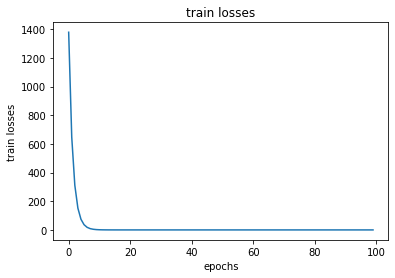

In [18]:
## We plot the train losses

plot_train_losses(loss.shape[0], loss, 'Coordinate_descent_CFAR10_3_class')

In [ ]:
## We plot the test accuracy

plot_test_accuracy(accuracy_test.shape[0], accuracy_test, 'Coordinate_descent_CFAR10_3_class')